# Representation with a Feature Cross

In this exercise, you'll experiment with different ways to represent features.

https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/representation_with_a_feature_cross.ipynb?utm_source=mlcc&utm_campaign=colab-external&utm_medium=referral&utm_content=representation_tf2-colab&hl=en

## Learning Objectives:

After doing this Colab, you'll know how to:

  * Use [`tf.feature_column`](https://www.tensorflow.org/api_docs/python/tf/feature_column) methods to represent features in different ways.
  * Represent features as [bins](https://developers.google.com/machine-learning/glossary/#bucketing). 
  * Cross bins to create a [feature cross](https://developers.google.com/machine-learning/glossary/#feature_cross). 

## The Dataset
  
Like several of the previous Colabs, this exercise uses the [California Housing Dataset](https://developers.google.com/machine-learning/crash-course/california-housing-data-description).

## Representation
`Feature engineering` means transforming raw data into a feature vector. Many ML models require features to be represented as real-numbered vectors. For numerical raw data, we may directly copy them over into the feature vector. For categorical data, we can create a binary vector to one-hot-encode or multi-hot-encode the different categories. If there are too many categories, e.g. explicitly creating a binary vector of 1,000,000 elements where only 1 or 2 elements are true is a very inefficient representation in terms of both storage and computation time when processing these vectors. In this situation, a common approach is to use a [sparse representation](https://developers.google.com/machine-learning/glossary#sparse_representation) in which only nonzero values are stored. In sparse representations, an independent model weight is still learned for each feature value, as described above.

Now we explore what kinds of values actually make good features within those feature vectors. Some criteria for good features are:

- **Avoid rarely used discrete feature values.** Good feature values should appear more than 5 or so times in a data set.
- **Prefer clear and obvious meanings.** In some cases, noisy data (rather than bad engineering choices) causes unclear values. 
- **Don't mix "magic" values with actual data.** Good floating-point features don't contain peculiar out-of-range discontinuities or "magic" values.
    - Often missing values are represented with magic values. For discrete variables, add a new value/level to indicate missing entries. For continuous variables, we may interpolate using the mean.
- **Account for upstream instability.** The definition of a feature shouldn't change over time.

## Data normalization
`Feature scaling` is generally performed during data preprocessing. Scaling means converting floating-point feature values from their natural range (for example, 100 to 900) into a standard range (for example, 0 to 1 or -1 to +1). If a feature set consists of multiple features, then feature scaling provides the following benefits:

1. Helps gradient descent converge more quickly.
2. Helps avoid the "NaN trap", in which one number in the model becomes a `NaN` (e.g., when a value exceeds the floating-point precision limit during training), and — due to math operations — every other number in the model also eventually becomes a NaN.
3. Helps the model learn appropriate weights for each feature. Without feature scaling, the model will pay too much attention to the features having a wider range.

A popular method for scaling is to calculate the `z-score`:

$$
\text{z-score} = \frac{X - \mu}{\sigma}
$$

where $\mu$ is the sample mean and $\sigma$ is the standard deviation. Most z-scores would be between -3 and 3.

The influence of extreme `outliers` could be minimized by taking the log of every value (using the `roomsPerPerson` variable as an example). If the log-scaled values still have a long tail, we may `clip` the feature at an arbitrary value, e.g. 4.0. Despite the artifact at 4.0, the feature is still more useful than the original data.

For certain continuous variables where no obvious linear relationship exists between it and the label (e.g. `latitude`), we may divide it into `bins` to make it into a helpful predictor. This converts the continuous variable to a discrete variable.

## Data scrubbing
Until now, we've assumed that all the data used for training and testing was trustworthy. In real-life, many examples in data sets are unreliable due to one or more of the following:

- Omitted values. For instance, a person forgot to enter a value for a house's age.
- Duplicate examples. For example, a server mistakenly uploaded the same logs twice.
- Bad labels. For instance, a person mislabeled a picture of an oak tree as a maple.
- Bad feature values. For example, someone typed in an extra digit, or a thermometer was left out in the sun.

Once detected, you typically "fix" bad examples by removing them from the data set. To detect omitted values or duplicated examples, you can write a simple program. Detecting bad feature values or labels can be far trickier.

In addition to detecting bad individual examples, you must also detect bad data in the aggregate. Histograms are a great mechanism for visualizing your data in the aggregate. In addition, getting statistics like the following can help:

- Maximum and minimum
- Mean and median
- Standard deviation

> Read [this post](https://developers.google.com/machine-learning/guides/rules-of-ml/#ml_phase_ii_feature_engineering) for more information on feature engineering.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
%matplotlib inline

sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})

In [2]:
# Load data
train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")

# Scale the label to median house value in k$
train_df["median_house_value"] /= 1000.0
test_df["median_house_value"] /= 1000.0

# Shuffle the training set
shuffled_train_df = (train_df
                     .sample(frac=1, random_state=42)
                     .reset_index(drop=True))

/home/leyan/anaconda3/envs/tensorflow/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/leyan/anaconda3/envs/tensorflow/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/leyan/anaconda3/envs/tensorflow/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figur

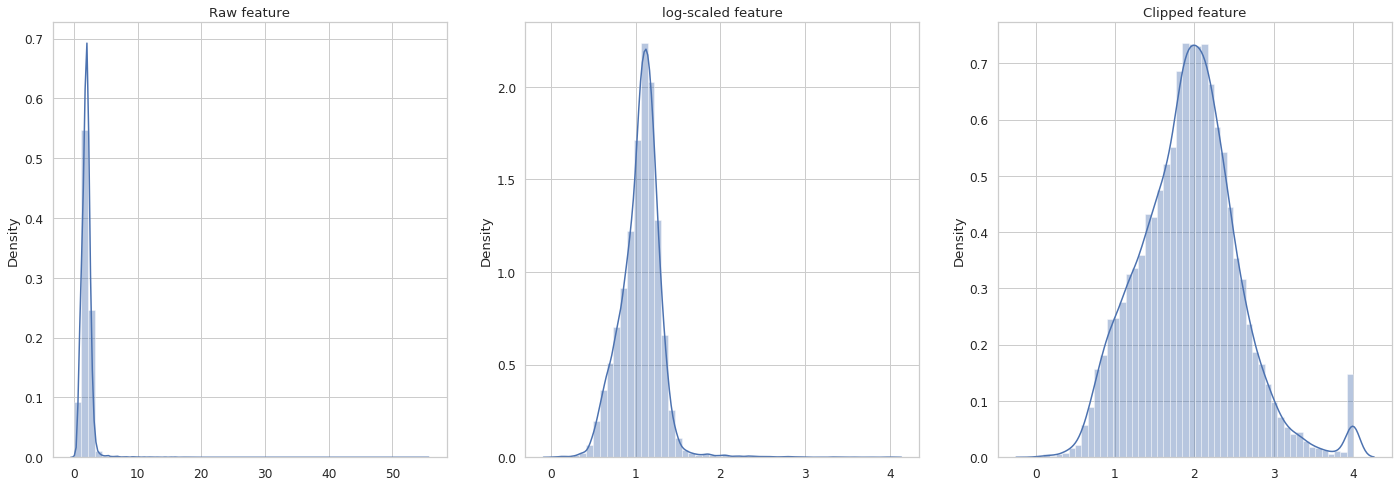

In [3]:
roomsPerPerson = train_df["total_rooms"] / train_df["population"]

fig, ax = plt.subplots(1, 3, figsize=(24, 8))
sns.distplot(roomsPerPerson, ax=ax[0])
ax[0].set_title("Raw feature")

logRoomsPerPerson = np.log(roomsPerPerson + 1)
sns.distplot(logRoomsPerPerson, ax=ax[1])
ax[1].set_title("log-scaled feature")

roomsPerPersonClipped = np.where(roomsPerPerson > 4.0, 4.0, roomsPerPerson)
sns.distplot(roomsPerPersonClipped, ax=ax[2])
ax[2].set_title("Clipped feature")

fig.show()

## Feature crosses
A `feature cross` is a synthetic feature formed by multiplying (crossing) two or more features. Crossing combinations of features can provide predictive abilities beyond what those features can provide individually.

The main reason we want feature crosses is that it allows us to incorporate non-linear learning into a linear learner. We can create many different kinds of feature crosses.

- `[A X B]`: a feature cross formed by multiplying the values of two features.
- `[A x B x C x D x E]`: a feature cross formed by multiplying the values of five features.
- `[A x A]`: a feature cross formed by squaring a single feature.

All above examples are for continuous variables. In practice, machine learning models seldom cross continuous features. However, machine learning models do frequently cross one-hot feature vectors. Think of feature crosses of one-hot feature vectors as logical conjunctions. For example, suppose we have two features: country and language. A one-hot encoding of each generates vectors with binary features that can be interpreted as country=USA, country=France or language=English, language=Spanish. Then, if you do a feature cross of these one-hot encodings, you get binary features that can be interpreted as logical conjunctions, such as: country:usa AND language:spanish.

In terms of dimensions, $A_{1 \times 4} \times B_{1 \times 3} = C_{1 \times 12}$. $C$ is the `outer product` of $A$ and $B$. In Python we can use `numpy.outer` or `numpy.einsum` to calculate it.

Linear learners scale well to massive data. Using feature crosses on massive data sets is one efficient strategy for learning highly complex models. [Neural networks](https://developers.google.com/machine-learning/crash-course/introduction-to-neural-networks) provide another strategy.

In [4]:
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
from sklearn.preprocessing import OrdinalEncoder
from tqdm import tqdm
from IPython.display import clear_output, display

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

### Represent latitude and longitude as floating-point values
> The original Colab also introduced `feature columns` in Tensorflow, which we'll ignore here.

Previously we've been training on one feature (raw or synthetic). Now we train on two features. A neighborhood's location is typically the most important feature in determining a house's value. The California Housing dataset provides two features, `latitude` and `longitude` that identify each neighborhood's location. 

First, we build the model with latitude and longitude as floating-point-valued features.

In [5]:
from sklearn.model_selection import train_test_split

# Map features and labels into a tensor dataset
class LocationDataset(Dataset):
    def __init__(self, df, x_name, y_name):
        self.x = torch.tensor(df[x_name].to_numpy().reshape(-1, len(x_name))).float()
        self.y = torch.tensor(df[y_name].to_numpy().reshape(-1, 1)).float()
    
    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])
    
    def __len__(self):
        return len(self.y)
    

dat = LocationDataset(shuffled_train_df, ["latitude", "longitude"], "median_house_value")
test_dat = LocationDataset(test_df, ["latitude", "longitude"], "median_house_value")

In [6]:
# Define the model
class LinearRegressionModel(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.linear = nn.Linear(num_features, 1)
        
    def forward(self, x):
        y_hat = self.linear(x)
        return y_hat
    

def make_train_step(model, loss_fn, optimizer):
    def train_step(x, y):
        model.train()
        
        y_hat = model(x)
        loss = loss_fn(y_hat, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        return loss.item()

    return train_step

In [7]:
import math
from barbar import Bar

# Hyperparameters
learning_rate = 0.05
epochs = 30
batch_size = 100

# For now we use the entire dataset for training (no validation set)
torch.manual_seed(42)
model = LinearRegressionModel(2).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr = learning_rate)

# train_loader = DataLoader(dataset=dat, batch_size=batch_size, shuffle=True)

train_ds, valid_ds = train_test_split(dat, test_size=0.2)
train_loader=DataLoader(train_ds,batch_size=batch_size,shuffle=False)
valid_loader=DataLoader(valid_ds,batch_size=batch_size,shuffle=False)

losses = []
# train_step = make_train_step(my_model, criterion, optimizer)

epoch_train_loss = []

epoch_valid_loss = []

for epoch in range(epochs):
    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []    
    
    # for batch in tqdm(trainloader):
    for x_batch, y_batch in Bar(train_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        # print(X)
        y_hat = model(x_batch)
        loss = criterion(y_hat, y_batch) #rmse
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()  
        
        # Record the loss and accuracy.
        losses.append(loss.item())
        train_loss.append(loss.item())
        
    train_loss = sum(train_loss) / len(train_loss)
    
    epoch_train_loss.append(math.sqrt(train_loss))
   
    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()
    
    # These are used to record information in validation.
    valid_loss = []
    
    # Iterate the validation set by batches.
    for x_batch, y_batch in Bar(valid_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device) 
       
        y_hat = model(x_batch)
        loss = criterion(y_hat, y_batch) #rmse
        
        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        
     # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    epoch_valid_loss.append(math.sqrt(valid_loss))
        
    # Print the information.
    display(f"[ Epoch | {epoch + 1:03d}/{epochs:03d} ] \
          train_loss = {train_loss:.5f} root_mean_squared_error = {math.sqrt(train_loss):.5f}  | \
          valid_loss = {valid_loss:.5f} val_root_mean_squared_error = {math.sqrt(valid_loss):.5f}")

print("Defined the build_model and train_model functions.")

test_loader = DataLoader(dataset=test_dat, batch_size=batch_size)
test_losses = []
with torch.no_grad():
    for x_test, y_test in test_loader:
        x_test, y_test = x_test.to(device), y_test.to(device)
        y_hat = model(x_test)
        loss = criterion(y_hat, y_test)
        test_losses.append(loss.item())
    
print(f"Test set loss: {np.mean(test_losses):.4f}")
print(model.state_dict())

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 001/030 ]           train_loss = 14564.57434 root_mean_squared_error = 120.68378  |           valid_loss = 14012.42400 val_root_mean_squared_error = 118.37409'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 002/030 ]           train_loss = 13526.56923 root_mean_squared_error = 116.30378  |           valid_loss = 13971.39513 val_root_mean_squared_error = 118.20066'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 003/030 ]           train_loss = 13496.56163 root_mean_squared_error = 116.17470  |           valid_loss = 13921.83959 val_root_mean_squared_error = 117.99085'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 004/030 ]           train_loss = 13455.88719 root_mean_squared_error = 115.99951  |           valid_loss = 13872.86164 val_root_mean_squared_error = 117.78311'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 005/030 ]           train_loss = 13412.94492 root_mean_squared_error = 115.81427  |           valid_loss = 13826.18319 val_root_mean_squared_error = 117.58479'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 006/030 ]           train_loss = 13371.34511 root_mean_squared_error = 115.63453  |           valid_loss = 13781.94118 val_root_mean_squared_error = 117.39651'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 007/030 ]           train_loss = 13331.84648 root_mean_squared_error = 115.46362  |           valid_loss = 13740.04868 val_root_mean_squared_error = 117.21795'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 008/030 ]           train_loss = 13294.49947 root_mean_squared_error = 115.30178  |           valid_loss = 13700.38775 val_root_mean_squared_error = 117.04866'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 009/030 ]           train_loss = 13259.21887 root_mean_squared_error = 115.14868  |           valid_loss = 13662.84079 val_root_mean_squared_error = 116.88816'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 010/030 ]           train_loss = 13225.89781 root_mean_squared_error = 115.00390  |           valid_loss = 13627.29570 val_root_mean_squared_error = 116.73601'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 011/030 ]           train_loss = 13194.43032 root_mean_squared_error = 114.86701  |           valid_loss = 13593.64502 val_root_mean_squared_error = 116.59179'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 012/030 ]           train_loss = 13164.71517 root_mean_squared_error = 114.73759  |           valid_loss = 13561.78774 val_root_mean_squared_error = 116.45509'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 013/030 ]           train_loss = 13136.65596 root_mean_squared_error = 114.61525  |           valid_loss = 13531.62701 val_root_mean_squared_error = 116.32552'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 014/030 ]           train_loss = 13110.16175 root_mean_squared_error = 114.49961  |           valid_loss = 13503.07206 val_root_mean_squared_error = 116.20272'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 015/030 ]           train_loss = 13085.14575 root_mean_squared_error = 114.39032  |           valid_loss = 13476.03619 val_root_mean_squared_error = 116.08633'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 016/030 ]           train_loss = 13061.52629 root_mean_squared_error = 114.28703  |           valid_loss = 13450.43739 val_root_mean_squared_error = 115.97602'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 017/030 ]           train_loss = 13039.22600 root_mean_squared_error = 114.18943  |           valid_loss = 13426.19818 val_root_mean_squared_error = 115.87147'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 018/030 ]           train_loss = 13018.17143 root_mean_squared_error = 114.09720  |           valid_loss = 13403.24480 val_root_mean_squared_error = 115.77238'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 019/030 ]           train_loss = 12998.29314 root_mean_squared_error = 114.01006  |           valid_loss = 13381.50827 val_root_mean_squared_error = 115.67847'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 020/030 ]           train_loss = 12979.52587 root_mean_squared_error = 113.92772  |           valid_loss = 13360.92176 val_root_mean_squared_error = 115.58945'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 021/030 ]           train_loss = 12961.80718 root_mean_squared_error = 113.84993  |           valid_loss = 13341.42325 val_root_mean_squared_error = 115.50508'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 022/030 ]           train_loss = 12945.07853 root_mean_squared_error = 113.77644  |           valid_loss = 13322.95310 val_root_mean_squared_error = 115.42510'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 023/030 ]           train_loss = 12929.28422 root_mean_squared_error = 113.70701  |           valid_loss = 13305.45620 val_root_mean_squared_error = 115.34928'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 024/030 ]           train_loss = 12914.37215 root_mean_squared_error = 113.64142  |           valid_loss = 13288.87997 val_root_mean_squared_error = 115.27740'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 025/030 ]           train_loss = 12900.29270 root_mean_squared_error = 113.57946  |           valid_loss = 13273.17360 val_root_mean_squared_error = 115.20926'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 026/030 ]           train_loss = 12886.99925 root_mean_squared_error = 113.52092  |           valid_loss = 13258.28981 val_root_mean_squared_error = 115.14465'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 027/030 ]           train_loss = 12874.44704 root_mean_squared_error = 113.46562  |           valid_loss = 13244.18446 val_root_mean_squared_error = 115.08338'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 028/030 ]           train_loss = 12862.59469 root_mean_squared_error = 113.41338  |           valid_loss = 13230.81503 val_root_mean_squared_error = 115.02528'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 029/030 ]           train_loss = 12851.40280 root_mean_squared_error = 113.36403  |           valid_loss = 13218.14129 val_root_mean_squared_error = 114.97018'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 030/030 ]           train_loss = 12840.83389 root_mean_squared_error = 113.31740  |           valid_loss = 13206.12569 val_root_mean_squared_error = 114.91791'

Defined the build_model and train_model functions.
Test set loss: 12243.3804
OrderedDict([('linear.weight', tensor([[-8.5629, -4.2620]], device='cuda:0')), ('linear.bias', tensor([2.7050], device='cuda:0'))])


/home/leyan/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  This is separate from the ipykernel package so we can avoid doing imports until


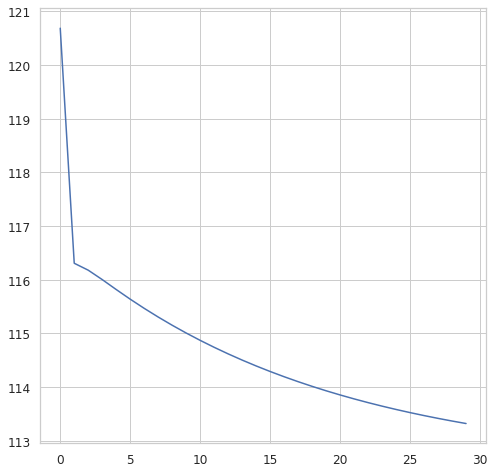

In [8]:
fig = plt.figure(figsize=(8, 8))
sns.lineplot(x=np.arange(0, epochs), y=epoch_train_loss)
fig.show()

Representing latitude and longitude as floating-point values does not have much predictive power. For example, neighborhoods at latitude 35 are not 36/35 more valuable (or 35/36 less valuable) than houses at latitude 36.

Representing `latitude` and `longitude` as floating-point values provides almost no predictive power. We're only using the raw values to establish a baseline for future experiments with better representations.

### Represent latitude and longitude in buckets
The following code cell represents latitude and longitude in buckets (bins). Each bin represents all the neighborhoods within a single degree. For example,
neighborhoods at latitude 35.4 and 35.8 are in the same bucket, but neighborhoods in latitude 35.4 and 36.2 are in different buckets. 

The model will learn a separate weight for each bucket. For example, the model will learn one weight for all the neighborhoods in the `35` bin, a different weight for neighborhoods in the `36` bin, and so on. This representation will create approximately 20 buckets: 10 buckets for `latitude` and 10 buckets for `longitude`.

In [9]:
latitude_enc, longtitude_enc = OrdinalEncoder(), OrdinalEncoder()

shuffled_train_df["latitude_bin"] = latitude_enc.fit_transform(shuffled_train_df["latitude"].astype(np.int).to_numpy().reshape(-1, 1))
shuffled_train_df["longitude_bin"] = longtitude_enc.fit_transform(shuffled_train_df["longitude"].astype(np.int).to_numpy().reshape(-1, 1))

test_df["latitude_bin"] = latitude_enc.transform(test_df["latitude"].astype(np.int).to_numpy().reshape(-1, 1))
test_df["longitude_bin"] = longtitude_enc.transform(test_df["longitude"].astype(np.int).to_numpy().reshape(-1, 1))

In [10]:
class BinnedLocationDataset(Dataset):
    def __init__(self, df, x_name, y_name):
        self.x = torch.tensor(df[x_name].astype(int).to_numpy().reshape(-1, len(x_name)))
        self.x = nn.functional.one_hot(self.x)  # one-hot encode each feature
        self.x = self.x.reshape(self.x.shape[0], -1).float()  # flatten multiple features into one matrix
        self.y = torch.tensor(df[y_name].to_numpy().reshape(-1, 1), dtype=torch.float)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])
    
    def __len__(self):
        return len(self.y)
    

dat = BinnedLocationDataset(shuffled_train_df, ["latitude_bin", "longitude_bin"], "median_house_value")
test_dat = BinnedLocationDataset(test_df, ["latitude_bin", "longitude_bin"], "median_house_value")

In [11]:
# Hyperparameters
learning_rate = 0.07
epochs = 35
batch_size = 100

# For now we use the entire dataset for training (no validation set)
torch.manual_seed(42)
model = LinearRegressionModel(dat.x.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr = learning_rate)

train_ds, valid_ds = train_test_split(dat, test_size=0.2)
train_loader=DataLoader(train_ds,batch_size=batch_size,shuffle=False)
valid_loader=DataLoader(valid_ds,batch_size=batch_size,shuffle=False)

losses = []
# train_step = make_train_step(my_model, criterion, optimizer)

epoch_train_loss = []

epoch_valid_loss = []

for epoch in range(epochs):
    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []    
    
    # for batch in tqdm(trainloader):
    for x_batch, y_batch in Bar(train_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        # print(X)
        y_hat = model(x_batch)
        loss = criterion(y_hat, y_batch) #rmse
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()  
        
        # Record the loss and accuracy.
        losses.append(loss.item())
        train_loss.append(loss.item())
        
    train_loss = sum(train_loss) / len(train_loss)
    
    epoch_train_loss.append(math.sqrt(train_loss))
   
    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()
    
    # These are used to record information in validation.
    valid_loss = []
    
    # Iterate the validation set by batches.
    for x_batch, y_batch in Bar(valid_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device) 
       
        y_hat = model(x_batch)
        loss = criterion(y_hat, y_batch) #rmse
        
        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        
     # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    epoch_valid_loss.append(math.sqrt(valid_loss))
        
    # Print the information.
    display(f"[ Epoch | {epoch + 1:03d}/{epochs:03d} ] \
          train_loss = {train_loss:.5f} root_mean_squared_error = {math.sqrt(train_loss):.5f}  | \
          valid_loss = {valid_loss:.5f} val_root_mean_squared_error = {math.sqrt(valid_loss):.5f}")

print("Defined the build_model and train_model functions.")

test_loader = DataLoader(dataset=test_dat, batch_size=batch_size)
test_losses = []
with torch.no_grad():
    for x_test, y_test in test_loader:
        x_test, y_test = x_test.to(device), y_test.to(device)
        y_hat = model(x_test)
        loss = criterion(y_hat, y_test)
        test_losses.append(loss.item())
    
print(f"Test set loss: {np.mean(test_losses):.4f}")
print(model.state_dict())

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 001/035 ]           train_loss = 44638.26014 root_mean_squared_error = 211.27768  |           valid_loss = 39603.84208 val_root_mean_squared_error = 199.00714'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 002/035 ]           train_loss = 34250.31645 root_mean_squared_error = 185.06841  |           valid_loss = 31552.66159 val_root_mean_squared_error = 177.63069'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 003/035 ]           train_loss = 27418.41958 root_mean_squared_error = 165.58508  |           valid_loss = 25471.50155 val_root_mean_squared_error = 159.59794'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 004/035 ]           train_loss = 22181.23910 root_mean_squared_error = 148.93367  |           valid_loss = 20768.81164 val_root_mean_squared_error = 144.11388'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 005/035 ]           train_loss = 18193.00601 root_mean_squared_error = 134.88145  |           valid_loss = 17233.17653 val_root_mean_squared_error = 131.27519'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 006/035 ]           train_loss = 15273.82593 root_mean_squared_error = 123.58732  |           valid_loss = 14704.80492 val_root_mean_squared_error = 121.26337'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 007/035 ]           train_loss = 13257.62077 root_mean_squared_error = 115.14174  |           valid_loss = 13014.23949 val_root_mean_squared_error = 114.07997'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 008/035 ]           train_loss = 11967.11538 root_mean_squared_error = 109.39431  |           valid_loss = 11977.99387 val_root_mean_squared_error = 109.44402'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 009/035 ]           train_loss = 11216.55698 root_mean_squared_error = 105.90825  |           valid_loss = 11401.68703 val_root_mean_squared_error = 106.77868'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 010/035 ]           train_loss = 10816.38878 root_mean_squared_error = 104.00187  |           valid_loss = 11102.90000 val_root_mean_squared_error = 105.37030'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 011/035 ]           train_loss = 10609.36638 root_mean_squared_error = 103.00178  |           valid_loss = 10950.48495 val_root_mean_squared_error = 104.64456'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 012/035 ]           train_loss = 10498.82586 root_mean_squared_error = 102.46378  |           valid_loss = 10870.47037 val_root_mean_squared_error = 104.26155'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 013/035 ]           train_loss = 10437.29225 root_mean_squared_error = 102.16307  |           valid_loss = 10825.75852 val_root_mean_squared_error = 104.04691'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 014/035 ]           train_loss = 10400.79356 root_mean_squared_error = 101.98428  |           valid_loss = 10797.43177 val_root_mean_squared_error = 103.91069'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 015/035 ]           train_loss = 10376.46520 root_mean_squared_error = 101.86494  |           valid_loss = 10776.46869 val_root_mean_squared_error = 103.80977'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 016/035 ]           train_loss = 10357.98173 root_mean_squared_error = 101.77417  |           valid_loss = 10759.01438 val_root_mean_squared_error = 103.72567'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 017/035 ]           train_loss = 10342.49212 root_mean_squared_error = 101.69804  |           valid_loss = 10743.51209 val_root_mean_squared_error = 103.65091'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 018/035 ]           train_loss = 10328.73542 root_mean_squared_error = 101.63039  |           valid_loss = 10729.31417 val_root_mean_squared_error = 103.58240'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 019/035 ]           train_loss = 10316.12639 root_mean_squared_error = 101.56833  |           valid_loss = 10716.11770 val_root_mean_squared_error = 103.51868'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 020/035 ]           train_loss = 10304.36643 root_mean_squared_error = 101.51043  |           valid_loss = 10703.75121 val_root_mean_squared_error = 103.45893'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 021/035 ]           train_loss = 10293.28589 root_mean_squared_error = 101.45583  |           valid_loss = 10692.10014 val_root_mean_squared_error = 103.40261'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 022/035 ]           train_loss = 10282.77717 root_mean_squared_error = 101.40403  |           valid_loss = 10681.07696 val_root_mean_squared_error = 103.34930'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 023/035 ]           train_loss = 10272.76517 root_mean_squared_error = 101.35465  |           valid_loss = 10670.61121 val_root_mean_squared_error = 103.29865'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 024/035 ]           train_loss = 10263.19464 root_mean_squared_error = 101.30743  |           valid_loss = 10660.64483 val_root_mean_squared_error = 103.25040'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 025/035 ]           train_loss = 10254.02226 root_mean_squared_error = 101.26215  |           valid_loss = 10651.12860 val_root_mean_squared_error = 103.20431'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 026/035 ]           train_loss = 10245.21406 root_mean_squared_error = 101.21864  |           valid_loss = 10642.02192 val_root_mean_squared_error = 103.16018'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 027/035 ]           train_loss = 10236.74162 root_mean_squared_error = 101.17678  |           valid_loss = 10633.29015 val_root_mean_squared_error = 103.11785'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 028/035 ]           train_loss = 10228.58124 root_mean_squared_error = 101.13645  |           valid_loss = 10624.90447 val_root_mean_squared_error = 103.07718'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 029/035 ]           train_loss = 10220.71299 root_mean_squared_error = 101.09754  |           valid_loss = 10616.84007 val_root_mean_squared_error = 103.03805'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 030/035 ]           train_loss = 10213.11964 root_mean_squared_error = 101.05998  |           valid_loss = 10609.07550 val_root_mean_squared_error = 103.00037'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 031/035 ]           train_loss = 10205.78661 root_mean_squared_error = 101.02369  |           valid_loss = 10601.59345 val_root_mean_squared_error = 102.96404'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 032/035 ]           train_loss = 10198.70011 root_mean_squared_error = 100.98861  |           valid_loss = 10594.37750 val_root_mean_squared_error = 102.92899'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 033/035 ]           train_loss = 10191.84890 root_mean_squared_error = 100.95469  |           valid_loss = 10587.41434 val_root_mean_squared_error = 102.89516'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 034/035 ]           train_loss = 10185.22267 root_mean_squared_error = 100.92186  |           valid_loss = 10580.69177 val_root_mean_squared_error = 102.86249'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 035/035 ]           train_loss = 10178.81198 root_mean_squared_error = 100.89010  |           valid_loss = 10574.19824 val_root_mean_squared_error = 102.83092'

Defined the build_model and train_model functions.
Test set loss: 10089.7145
OrderedDict([('linear.weight', tensor([[ 83.0087,  94.3561,  95.3402,  -4.3804,   4.8662,  76.8536, -10.4320,
         -38.8629, -84.0665, -91.9474,   0.1853,  90.3777,  75.7793, 125.0590,
          71.9809,  23.3982,  24.0780,  69.7706,  32.3323, -21.2199, -86.0780,
         -87.4760]], device='cuda:0')), ('linear.bias', tensor([78.6359], device='cuda:0'))])


/home/leyan/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  This is separate from the ipykernel package so we can avoid doing imports until


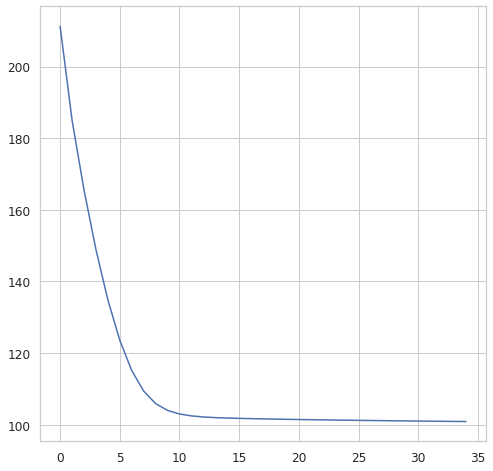

In [12]:
fig = plt.figure(figsize=(8, 8))
sns.lineplot(x=np.arange(0, epochs), y=epoch_train_loss)
fig.show()

Bucket representation outperformed floating-point representations (MSE ~13000 -> ~10000). However, you can still do far better.

### Represent location as a feature cross
Representing location as a feature cross should produce better results. We've represented latitude in one-dimensional buckets and longitude in another series of one-dimensional buckets. Real-world locations, however, exist in two dimensions. Therefore, you should represent location as a two-dimensional feature cross. That is, you'll cross the 10 or so latitude buckets with the 10 or so longitude buckets to create a grid of 100 cells. The model will learn separate weights for each of the cells.

In [13]:
def get_bins(x, step):
    x_min, x_max = int(np.min(x)), int(np.max(x))
    return np.linspace(x_min, x_max, int((x_max-x_min)/step)+1)

def bin_feature(enc, x, bins, fit=True):
    x_binned = pd.cut(x, bins).astype(str).to_numpy().reshape(-1, 1)
    if fit:
        enc.fit(x_binned)
    return enc.transform(x_binned)

In [14]:
class CrossBinnedLocationDataset(Dataset):
    def __init__(self, x1, x2, y):
        x1 = torch.tensor(x1.astype(int).to_numpy())
        x2 = torch.tensor(x2.astype(int).to_numpy())
        
        # one-hot encode each feature
        x1 = nn.functional.one_hot(x1)
        x2 = nn.functional.one_hot(x2)
        
        # cross the two tensors
        self.x = torch.tensor(np.einsum("...i,...j", x1, x2).reshape(x1.shape[0], -1)).float()
        self.y = torch.tensor(y.to_numpy().reshape(-1, 1), dtype=torch.float)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])
    
    def __len__(self):
        return len(self.y)

In [15]:
resolution_in_degrees = 1.0
learning_rate = 0.04
epochs = 35

In [16]:
# Bin features
latitude_enc, longtitude_enc = OrdinalEncoder(), OrdinalEncoder()

latitude_bins = get_bins(shuffled_train_df["latitude"], resolution_in_degrees)
longitude_bins = get_bins(shuffled_train_df["longitude"], resolution_in_degrees)

shuffled_train_df["latitude_bin"] = bin_feature(latitude_enc, shuffled_train_df["latitude"], latitude_bins)
shuffled_train_df["longitude_bin"] = bin_feature(longtitude_enc, shuffled_train_df["longitude"], longitude_bins)
test_df["latitude_bin"] = bin_feature(latitude_enc, test_df["latitude"], latitude_bins, fit=False)
test_df["longitude_bin"] = bin_feature(longtitude_enc, test_df["longitude"], longitude_bins, fit=False)

# Cross features and convert to Dataset
dat = CrossBinnedLocationDataset(shuffled_train_df["latitude_bin"], shuffled_train_df["longitude_bin"], shuffled_train_df["median_house_value"])
test_dat = CrossBinnedLocationDataset(test_df["latitude_bin"], test_df["longitude_bin"], test_df["median_house_value"])

torch.manual_seed(42)
model = LinearRegressionModel(dat.x.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr = learning_rate)

train_ds, valid_ds = train_test_split(dat, test_size=0.2)
train_loader=DataLoader(train_ds,batch_size=batch_size,shuffle=False)
valid_loader=DataLoader(valid_ds,batch_size=batch_size,shuffle=False)

losses = []
# train_step = make_train_step(my_model, criterion, optimizer)

epoch_train_loss = []

epoch_valid_loss = []

for epoch in range(epochs):
    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []    
    
    # for batch in tqdm(trainloader):
    for x_batch, y_batch in Bar(train_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        # print(X)
        y_hat = model(x_batch)
        loss = criterion(y_hat, y_batch) #rmse
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()  
        
        # Record the loss and accuracy.
        losses.append(loss.item())
        train_loss.append(loss.item())
        
    train_loss = sum(train_loss) / len(train_loss)
    
    epoch_train_loss.append(math.sqrt(train_loss))
   
    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()
    
    # These are used to record information in validation.
    valid_loss = []
    
    # Iterate the validation set by batches.
    for x_batch, y_batch in Bar(valid_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device) 
       
        y_hat = model(x_batch)
        loss = criterion(y_hat, y_batch) #rmse
        
        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        
     # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    epoch_valid_loss.append(math.sqrt(valid_loss))
        
    # Print the information.
    display(f"[ Epoch | {epoch + 1:03d}/{epochs:03d} ] \
          train_loss = {train_loss:.5f} root_mean_squared_error = {math.sqrt(train_loss):.5f}  | \
          valid_loss = {valid_loss:.5f} val_root_mean_squared_error = {math.sqrt(valid_loss):.5f}")

print("Defined the build_model and train_model functions.")

test_loader = DataLoader(dataset=test_dat, batch_size=batch_size)
test_losses = []
with torch.no_grad():
    for x_test, y_test in test_loader:
        x_test, y_test = x_test.to(device), y_test.to(device)
        y_hat = model(x_test)
        loss = criterion(y_hat, y_test)
        test_losses.append(loss.item())
    
print(f"Test set loss: {np.mean(test_losses):.4f}")
print(model.state_dict())

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 001/035 ]           train_loss = 52100.49199 root_mean_squared_error = 228.25532  |           valid_loss = 47729.69301 val_root_mean_squared_error = 218.47126'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 002/035 ]           train_loss = 47317.10969 root_mean_squared_error = 217.52496  |           valid_loss = 43793.06629 val_root_mean_squared_error = 209.26793'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 003/035 ]           train_loss = 43584.23014 root_mean_squared_error = 208.76836  |           valid_loss = 40311.62385 val_root_mean_squared_error = 200.77755'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 004/035 ]           train_loss = 40185.13329 root_mean_squared_error = 200.46230  |           valid_loss = 37088.66182 val_root_mean_squared_error = 192.58417'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 005/035 ]           train_loss = 37018.69445 root_mean_squared_error = 192.40243  |           valid_loss = 34080.81468 val_root_mean_squared_error = 184.60990'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 006/035 ]           train_loss = 34060.69939 root_mean_squared_error = 184.55541  |           valid_loss = 31276.32807 val_root_mean_squared_error = 176.85115'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 007/035 ]           train_loss = 31303.82037 root_mean_squared_error = 176.92886  |           valid_loss = 28670.60168 val_root_mean_squared_error = 169.32395'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 008/035 ]           train_loss = 28744.28491 root_mean_squared_error = 169.54140  |           valid_loss = 26260.08174 val_root_mean_squared_error = 162.04963'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 009/035 ]           train_loss = 26378.38821 root_mean_squared_error = 162.41425  |           valid_loss = 24040.59277 val_root_mean_squared_error = 155.05029'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 010/035 ]           train_loss = 24201.66549 root_mean_squared_error = 155.56884  |           valid_loss = 22007.38683 val_root_mean_squared_error = 148.34887'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 011/035 ]           train_loss = 22209.24111 root_mean_squared_error = 149.02765  |           valid_loss = 20155.69853 val_root_mean_squared_error = 141.97077'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 012/035 ]           train_loss = 20396.18257 root_mean_squared_error = 142.81520  |           valid_loss = 18480.67176 val_root_mean_squared_error = 135.94363'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 013/035 ]           train_loss = 18757.29499 root_mean_squared_error = 136.95727  |           valid_loss = 16976.87221 val_root_mean_squared_error = 130.29533'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 014/035 ]           train_loss = 17286.74927 root_mean_squared_error = 131.47908  |           valid_loss = 15637.96582 val_root_mean_squared_error = 125.05185'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 015/035 ]           train_loss = 15977.83717 root_mean_squared_error = 126.40347  |           valid_loss = 14456.74612 val_root_mean_squared_error = 120.23621'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 016/035 ]           train_loss = 14823.23625 root_mean_squared_error = 121.75071  |           valid_loss = 13425.77263 val_root_mean_squared_error = 115.86964'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 017/035 ]           train_loss = 13815.60547 root_mean_squared_error = 117.53980  |           valid_loss = 12537.83835 val_root_mean_squared_error = 111.97249'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 018/035 ]           train_loss = 12947.86915 root_mean_squared_error = 113.78870  |           valid_loss = 11785.83999 val_root_mean_squared_error = 108.56261'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 019/035 ]           train_loss = 12212.83172 root_mean_squared_error = 110.51168  |           valid_loss = 11162.09105 val_root_mean_squared_error = 105.65080'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 020/035 ]           train_loss = 11602.45548 root_mean_squared_error = 107.71469  |           valid_loss = 10657.53116 val_root_mean_squared_error = 103.23532'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 021/035 ]           train_loss = 11107.18932 root_mean_squared_error = 105.39065  |           valid_loss = 10261.14388 val_root_mean_squared_error = 101.29730'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 022/035 ]           train_loss = 10715.52372 root_mean_squared_error = 103.51581  |           valid_loss = 9959.60106 val_root_mean_squared_error = 99.79780'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 023/035 ]           train_loss = 10413.86564 root_mean_squared_error = 102.04835  |           valid_loss = 9737.31958 val_root_mean_squared_error = 98.67786'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 024/035 ]           train_loss = 10186.78910 root_mean_squared_error = 100.92962  |           valid_loss = 9577.00758 val_root_mean_squared_error = 97.86219'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 025/035 ]           train_loss = 10017.77056 root_mean_squared_error = 100.08881  |           valid_loss = 9461.14088 val_root_mean_squared_error = 97.26840'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 026/035 ]           train_loss = 9890.82875 root_mean_squared_error = 99.45265  |           valid_loss = 9374.62102 val_root_mean_squared_error = 96.82263'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 027/035 ]           train_loss = 9792.90571 root_mean_squared_error = 98.95911  |           valid_loss = 9307.18115 val_root_mean_squared_error = 96.47373'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 028/035 ]           train_loss = 9715.26685 root_mean_squared_error = 98.56605  |           valid_loss = 9253.23989 val_root_mean_squared_error = 96.19376'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 029/035 ]           train_loss = 9652.76719 root_mean_squared_error = 98.24850  |           valid_loss = 9209.90990 val_root_mean_squared_error = 95.96828'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 030/035 ]           train_loss = 9602.26640 root_mean_squared_error = 97.99115  |           valid_loss = 9175.35956 val_root_mean_squared_error = 95.78810'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 031/035 ]           train_loss = 9561.54049 root_mean_squared_error = 97.78313  |           valid_loss = 9148.10566 val_root_mean_squared_error = 95.64573'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 032/035 ]           train_loss = 9528.80323 root_mean_squared_error = 97.61559  |           valid_loss = 9126.82242 val_root_mean_squared_error = 95.53440'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 033/035 ]           train_loss = 9502.55385 root_mean_squared_error = 97.48104  |           valid_loss = 9110.33242 val_root_mean_squared_error = 95.44806'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 034/035 ]           train_loss = 9481.52715 root_mean_squared_error = 97.37313  |           valid_loss = 9097.62490 val_root_mean_squared_error = 95.38147'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 035/035 ]           train_loss = 9464.67221 root_mean_squared_error = 97.28655  |           valid_loss = 9087.85960 val_root_mean_squared_error = 95.33027'

Defined the build_model and train_model functions.
Test set loss: 9123.7180
OrderedDict([('linear.weight', tensor([[-7.2984e+00, -2.9742e+01,  5.6393e+01,  7.0777e+01, -2.0891e-02,
          1.9240e-02, -4.6420e-02,  5.5995e-02,  8.4052e-02, -6.9949e-02,
          8.2875e-02, -1.8994e+01, -3.3096e+01,  1.8682e+01,  1.0977e+02,
          9.7127e+01,  7.3501e-02,  1.4093e-02, -4.4511e-02,  2.4304e-02,
         -4.3930e-02, -1.1182e-02, -2.0069e+01, -1.3501e+01, -7.6091e+00,
          2.5959e+01,  1.3633e+02,  1.2483e+02,  4.9656e+01, -9.4172e-02,
          8.6108e-02, -8.0994e-02,  7.3610e-02,  1.5867e-02, -4.5477e+00,
         -9.1108e+00, -3.8944e+00, -3.2988e+01, -3.4068e+01,  7.3065e+01,
          3.1538e+01, -2.5856e-02,  4.0127e-02,  8.5127e-02,  5.5116e-02,
         -4.1683e-02,  5.5040e-02, -1.1350e+01, -6.3613e+00, -3.9596e+01,
         -3.6184e+01,  9.9004e+01,  7.0640e+01,  7.8235e-02,  2.7463e-02,
          3.9494e-02,  3.0154e-02, -1.6586e-03,  7.4619e-02,  2.2657e+01,
     

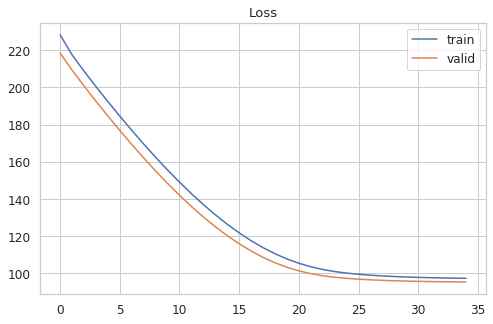

In [17]:
import matplotlib.pyplot as plt

# Loss curve
plt.plot(epoch_train_loss)
plt.plot(epoch_valid_loss)
plt.title('Loss')
plt.legend(['train', 'valid'])
plt.savefig('loss.png')
plt.show()

/home/leyan/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  This is separate from the ipykernel package so we can avoid doing imports until


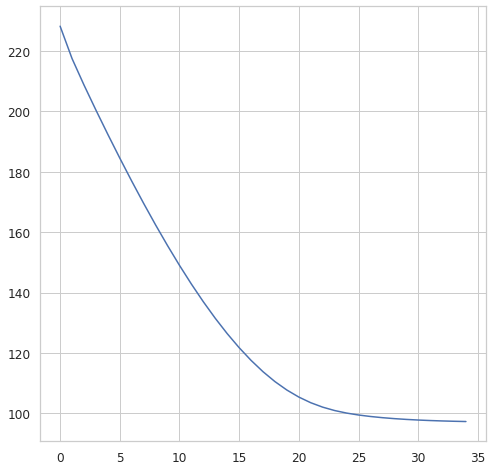

In [18]:
fig = plt.figure(figsize=(8, 8))
sns.lineplot(x=np.arange(0, epochs), y=epoch_train_loss)
fig.show()

representing these features as a feature cross produced much lower loss values than representing these features as buckets (MSE ~10000 -> ~9000). 

Return to the code cell in the "Represent location as a feature cross" section. Notice that `resolution_in_degrees` is set to 1.0. Therefore, each cell represents an area of 1.0 degree of latitude by 1.0 degree of longitude, which corresponds to a cell of 110 km by 90 km.  This resolution defines a rather large neighborhood. 

Experiment with `resolution_in_degrees` to answer the following questions:

1. What value of `resolution_in_degrees` produces the best results (lowest loss value)?
2. Why does loss increase when the value of `resolution_in_degrees` drops below a certain value?

Finally, answer the following question:

3. What feature (that does not exist in the California Housing Dataset) would
     be a better proxy for location than latitude X longitude.
     
Answers:
1. A resolution of ~0.4 degree provides the best results.
2. Below ~0.4 degree, loss increases because the dataset does not contain enough examples in each cell to accurately predict prices for those cells.
3. Postal code would be a far better feature than latitude X longitude, assuming that the dataset contained sufficient examples in each postal code.